

*   Merieme AMINE
*   Ibréhime TRAORE



# **Sentiment analysis of New York Times articles' comments**

## **1) Introduction**

Next to classic powers (executive, legislative and judicial), we have a fourth that is the media’s. They publish articles on different themes.. Given the diversity of the articles published and the heterogeneity of the readers, we start from the fact that the opinions given will allow us to understand what the readers think about current news and what one thinks about others’ opinions. Our aim will therefore be threefold: firstly to qualify the reader's sentiment on the subject of the article through his comment; secondly measure the popularity of his comment and finally analyze the feelings of other readers about his comment

## **2) Labelling of comments**

We firstly import comments and replies of April 2018. Then, we only focus on comments

In [0]:
# database 
import pandas as pd
df = pd.read_csv('comment.csv')
#a sample of the data for fast tokenization
print("Shape:  {0}".format(df.shape))
df.head()

Shape:  (10000, 34)


,approveDate,articleID,articleWordCount,commentBody,commentID,commentSequence,commentTitle,commentType,createDate,depth,editorsSelection,inReplyTo,newDesk,parentID,parentUserDisplayName,permID,picURL,printPage,recommendations,recommendedFlag,replyCount,reportAbuseFlag,sectionName,sharing,status,timespeople,trusted,typeOfMaterial,updateDate,userDisplayName,userID,userLocation,userTitle,userURL
0,1523814467,5ad071be068401528a2a87cd,2803.0,Picturesque?<br/><br/>Perhaps for now...but ju...,26739901.0,26739901.0,<br/>,comment,1523763439,1.0,False,0.0,RealEstate,0.0,NaN,26739901,https://graphics8.nytimes.com/images/apps/time...,1.0,16,NaN,0,NaN,Unknown,0,approved,0,0,News,1523814467,Robert J. Wlkinson,71538304.0,"Charlotte, NC",NaN,NaN
1,1522892736,5ac4059c068401528a2a1c89,809.0,Trump never grew up and is a dangerous parody ...,26601191.0,26601191.0,<br/>,comment,1522872318,1.0,False,0.0,OpEd,0.0,NaN,26601191,https://graphics8.nytimes.com/images/apps/time...,27.0,19,NaN,0,NaN,Unknown,0,approved,1,0,Op-Ed,1522892736,Andrea Landry,79346918.0,"Lynn, MA",NaN,NaN
2,1524580966,5adef237068401528a2aa532,1185.0,At what point will Alan Mulally be asked to co...,26849850.0,26849850.0,<br/>,comment,1524580962,1.0,False,0.0,Business,0.0,NaN,26849850,http://graphics8.nytimes.com/images/apps/times...,0.0,3,NaN,0,NaN,Unknown,0,approved,1,0,News,1524580966,Frank,5594037.0,"Chicago, IL",NaN,NaN
3,1523890541,5ad46d21068401528a2a8e11,489.0,In this picture I think these people went into...,26753951.0,26753951.0,<br/>,comment,1523890501,1.0,False,0.0,Learning,0.0,NaN,26753951,http://graphics8.nytimes.com/images/apps/times...,0.0,0,NaN,0,NaN,Unknown,0,approved,0,0,News,1523890541,Cadence Schwind,85408841.0,North Dakota,NaN,NaN
4,1524614389,5adf341f068401528a2aa5e8,1622.0,Wow. Who knew that a nominee for such an impor...,26858479.0,26858479.0,<br/>,comment,1524613672,1.0,False,0.0,Washington,0.0,NaN,26858479,http://graphics8.nytimes.com/images/apps/times...,1.0,10,NaN,0,NaN,Politics,1,approved,1,0,News,1524614389,JAS Resistance,17566461.0,California,NaN,NaN




> Now, we will labelize our comments



In [0]:
!pip install pyspark
!pip install transformers

In [0]:
#Import all the packages need to preprocess the data and calculate the sentiment
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
import string
import re
from nltk.corpus import stopwords
from nltk import sent_tokenize, word_tokenize, pos_tag
#from pyspark.sql.functions import udf
#from pyspark.sql.types import *
from nltk.corpus import sentiwordnet as swn
import sys

In [0]:
#Download the needed corpus 
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('sentiwordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package sentiwordnet to /root/nltk_data...
[nltk_data]   Package sentiwordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
# Ponctuations
points = stopwords.words('english')
def remove_stopwords(data_str):
    data_str = data_str.lower()
    comment = [word for word in data_str.split(" ") if word not in points]
    return ' '.join(comment)
def clean(astring):
  astring = astring.lower()
  num_re = re.compile('(\\d+)')
  punc_re = re.compile('[%s]' % re.escape(string.punctuation))
  data_str= punc_re.sub(' ', astring)
  astring = num_re.sub(' ', data_str)
  return " ".join(astring.split())

def tokenize(aString):
  a = word_tokenize(aString)
  #only return values long enough
  return a

#extract part of speech
def pos(tokenized_text):
    sent_tag_list = pos_tag(tokenized_text) 
    aList = []
    for word, tag in sent_tag_list:
        tagToUse = ''
        if tag.startswith('J'):
            tagToUse= 'a'
        elif tag.startswith('N'):
            tagToUse= 'n'
        elif tag.startswith('R'):
            tagToUse= 'r'
        elif tag.startswith('V'):
            tagToUse= 'v'
        else:
            continue
        aList.append((word, tagToUse))
    return aList

#lemmatize the commit comments  
lemmatizer = WordNetLemmatizer()
def lemmatize(array_of_word_for_a_comment):
  all_words_in_comment = []
  for word in array_of_word_for_a_comment:
    lemma = lemmatizer.lemmatize(word[0], pos=word[1])
    if not lemma:
      continue
    all_words_in_comment.append([lemma,word[1]])  
  return all_words_in_comment


#Labelize the sentiment 
def labelize(array_of_lemma_tag_for_a_comment):
    alist = [array_of_lemma_tag_for_a_comment]
    totalScore = 0
    count_words_included = 0
    for word in array_of_lemma_tag_for_a_comment:
        synset_forms = list(swn.senti_synsets(word[0], word[1]))
        if not synset_forms:
            continue
        synset = synset_forms[0] 
        totalScore = totalScore + synset.pos_score() - synset.neg_score()
        count_words_included = count_words_included +1
    final_dec = ''
    if count_words_included == 0:
        final_dec =  0  # 'N/A'
    elif totalScore == 0:
        final_dec =1 # 'Neu'        
    elif totalScore/count_words_included < 0:
        final_dec = 2 # 'Neg'
    elif totalScore/count_words_included > 0:
        final_dec = 3 #'Pos'
    return final_dec

In [0]:
def give_token(comment):
  return tokenize(clean(remove_stopwords(comment)))

def give_label(comment):
  return labelize(lemmatize(pos(give_token(comment))))

In [0]:
tokens=df['commentBody'].apply(give_token)
label=df['commentBody'].apply(give_label)

In [0]:
tokens=pd.Series(tokens,name='Tokens')
label=pd.Series(label,name='Labels')
base=pd.concat([label,df.loc[:,'commentBody'],tokens],axis=1,sort=False)
base.head()

,Labels,commentBody,Tokens
0,3,Picturesque?<br/><br/>Perhaps for now...but ju...,"[picturesque, br, br, perhaps, now, but, wait,..."
1,2,Trump never grew up and is a dangerous parody ...,"[trump, never, grew, dangerous, parody, man, c..."
2,2,At what point will Alan Mulally be asked to co...,"[point, alan, mulally, asked, come, back, fix,..."
3,3,In this picture I think these people went into...,"[picture, think, people, went, forest, study, ..."
4,3,Wow. Who knew that a nominee for such an impor...,"[wow, knew, nominee, important, critically, ne..."


In [0]:
def rm(x):
  removal_list=["br","’","s","https","www"]
  return([word for word in x if word not in removal_list])
base.Tokens=base['Tokens'].apply(rm)

In [0]:
base.head()

,Labels,commentBody,Tokens
0,3,Picturesque?<br/><br/>Perhaps for now...but ju...,"[picturesque, perhaps, now, but, wait, fate, b..."
1,2,Trump never grew up and is a dangerous parody ...,"[trump, never, grew, dangerous, parody, man, c..."
2,2,At what point will Alan Mulally be asked to co...,"[point, alan, mulally, asked, come, back, fix,..."
3,3,In this picture I think these people went into...,"[picture, think, people, went, forest, study, ..."
4,3,Wow. Who knew that a nominee for such an impor...,"[wow, knew, nominee, important, critically, ne..."


In [0]:
#topic modelling
from gensim.models import LdaModel
from gensim import corpora
import nltk
from string import punctuation

dictionary = corpora.Dictionary(base.Tokens)
corpus = [dictionary.doc2bow(text) for text in base.Tokens]

ldamodel = LdaModel(corpus, id2word=dictionary, num_topics=4)

In [0]:
!pip install pyLDAvis

     |████████████████████████████████| 1.6MB 2.8MB/s 
     |████████████████████████████████| 552kB 53.6MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-2.1.2-py2.py3-none-any.whl size=97711 sha256=4a94af2fee6e2fc2aa943117aad8dabce58c0db852777830d1be6b03d52a3e94
  Stored in directory: /root/.cache/pip/wheels/98/71/24/513a99e58bb6b8465bae4d2d5e9dba8f0bef8179e3051ac414
  Created wheel for funcy: filename=funcy-1.14-py2.py3-none-any.whl size=32042 sha256=e814547ee90a5a894a06232c6a7ab626b4a288846b8c500ff7f941e80199f032
  Stored in directory: /root/.cache/pip/wheels/20/5a/d8/1d875df03deae6f178dfdf70238cca33f948ef8a6f5209f2eb
Successfully built pyLDAvis funcy


In [0]:
import pyLDAvis.gensim
lda_display = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(lda_display)

## **3) Modelling**

# Predicting the popularity of a comment : 


In [0]:
import numpy as np
np.quantile(df.recommendations, 0.5)

6.0

In [0]:
np.quantile(df.recommendations, 0.8)

20.0

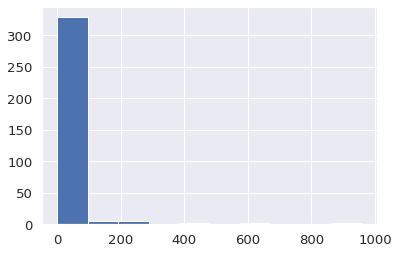

In [0]:
df.drop_duplicates().groupby(df.recommendations).size().hist()

We will consider that a comment is popular when the number of upvotes exceeds the 80th percentile, in this cas the median number of upvotes is 20.

In [0]:
X=base.Tokens.array
X = [' '.join(x) for x in X]
print(len(X), X[0])

10000 picturesque perhaps now but wait fate befalls quaint quiet well kept secrets moneyed set big city sweeps in imprints way life whether fits upon unspoiled landscape reinterprets historic architectural language what ken frampton calls vernacular name boutique artisanal every laughable luxury adjective used know quietly communicate unrelenting selfishness conformity makes transformation place related way life possible goodness barney bergdorf can t far behind in signing coveted leases there


In [0]:
df['pop'] =  np.where(df['recommendations']>20, 'very popular', (np.where(df['recommendations']>10, 'popular', 'neutral')))

In [0]:
y = df['pop']
print(y)
print(y.shape)

0            popular
1            popular
2            neutral
3            neutral
4            neutral
            ...     
9995         neutral
9996         neutral
9997    very popular
9998         neutral
9999         neutral
Name: pop, Length: 10000, dtype: object
(10000,)


In [0]:
y.value_counts()

neutral         6412
very popular    1995
popular         1593
Name: pop, dtype: int64

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
# create dev 20% test 20% (hence 50% from the 40%)
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

In [0]:
y_dev.value_counts()

neutral         1300
very popular     382
popular          318
Name: pop, dtype: int64

In [0]:
y_test.value_counts()

neutral         1253
very popular     438
popular          309
Name: pop, dtype: int64

In [0]:
#vectorizing X using CountVectorizer
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(6000, 23280)

In [0]:
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(2000, 23280)

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(6000, 3) (2000, 3)


First classification model is a basic Support Vector Machine.



In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1 ).fit(X_train_cv.toarray(), y_train_lb)

[LibLinear][LibLinear][LibLinear]

In [0]:
y_pred_svm = clf_svm.predict(X_dev_cv)
print(y_pred_svm.shape)

(2000, 3)


In [0]:
print(y_pred_svm[:5])
print(y_dev_lb[:5])

[[0 0 0]
 [0 0 1]
 [0 0 0]
 [1 0 0]
 [0 1 0]]
[[1 0 0]
 [1 0 0]
 [1 0 0]
 [1 0 0]
 [0 0 1]]


In [0]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sn
def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['neutral', 'popular', 'very popular']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

     neutral       0.67      0.78      0.72      1300
     popular       0.17      0.13      0.15       318
very popular       0.24      0.15      0.18       382

    accuracy                           0.56      2000
   macro avg       0.36      0.35      0.35      2000
weighted avg       0.51      0.56      0.53      2000



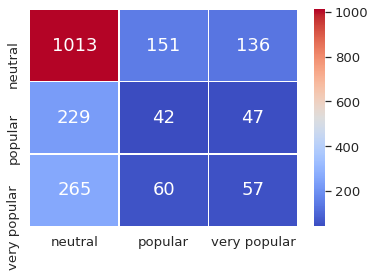

neutral 0.542142857142857
popular 0.5098695772478107
very popular 0.5364372666144617


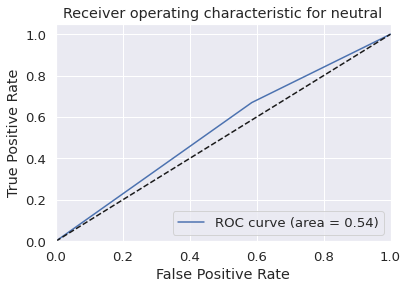

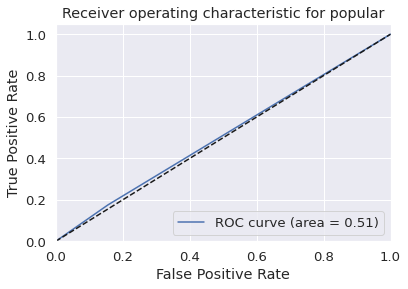

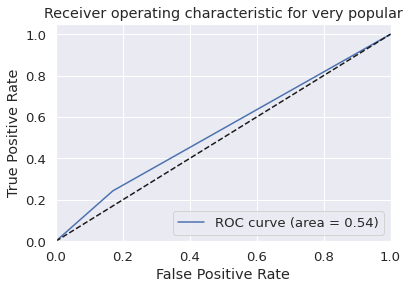

In [0]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm)

This model fails to classify the "popular" and "very popular" comments. We will try Random forests classification and compare the outcomes.

In [0]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier( max_depth=None, random_state=42,min_samples_split=3, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.6s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 100 out of 100 | elapsed:    0.2s finished
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral       0.65      1.00      0.79      1300
     popular       0.00      0.00      0.00       318
very popular       0.60      0.02      0.03       382

    accuracy                           0.65      2000
   macro avg       0.42      0.34      0.27      2000
weighted avg       0.54      0.65      0.52      2000



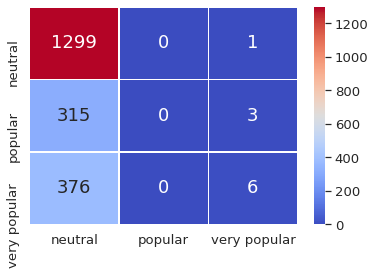

neutral 0.5364285714285714
popular 0.5
very popular 0.5066173091982216


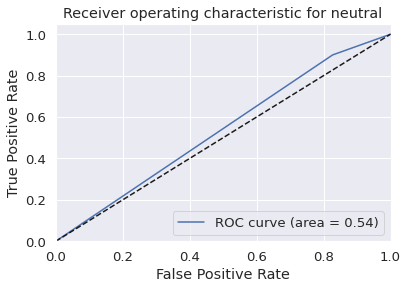

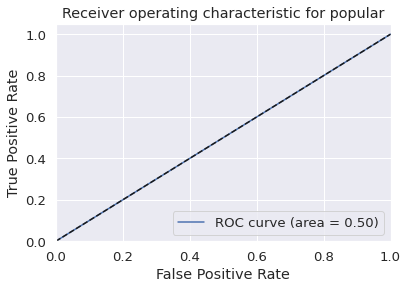

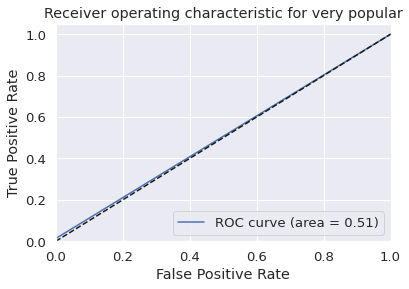

In [0]:
y_pred_rfc = rfc.predict(X_dev_cv)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )

In [0]:
#word2vec as an embedding method
#we need to train it on similar data. Since the field of the comments seem to be political, we will train it on a corpus in the same context.
! wget https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv

--2020-04-12 18:34:40--  https://d1p17r2m4rzlbo.cloudfront.net/wp-content/uploads/2016/03/Political-media-DFE.csv
Resolving d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)... 143.204.73.75, 143.204.73.103, 143.204.73.118, ...
Connecting to d1p17r2m4rzlbo.cloudfront.net (d1p17r2m4rzlbo.cloudfront.net)|143.204.73.75|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4309577 (4.1M) [application/octet-stream]
Saving to: ‘Political-media-DFE.csv.1’

Political-media-DFE 100%[===================>]   4.11M  3.40MB/s    in 1.2s    

2020-04-12 18:34:42 (3.40 MB/s) - ‘Political-media-DFE.csv.1’ saved [4309577/4309577]



In [0]:
import pandas as pd
df_pol = pd.read_csv('Political-media-DFE.csv', encoding='latin-1')

In [0]:
# Usage of Phrases and Phraser from gensim
import nltk
from gensim.models.phrases import Phrases, Phraser
from nltk.tokenize import TreebankWordTokenizer, TweetTokenizer
nltk.download('punkt')
sent_detector = nltk.data.load('tokenizers/punkt/english.pickle')

def remove_hashtags(tokens):
  tokens = map(lambda x: x.replace('#', ''), tokens)
  return list(tokens)

def remove_url(tokens):
  tokens = filter(lambda x: "http" not in x, tokens)
  return list(tokens)

def remove_html(tokens):
  tokens = filter(lambda x: x[0]+x[-1] != '<>', tokens)
  return list(tokens)

from tqdm import tqdm
def tokenize_url_hashtags(corpus, tweets=False):
  if tweets:
    tokenizer = TweetTokenizer()
  else:
    tokenizer = TreebankWordTokenizer()  
    # Life hack : treebank word tokenizer won't keep html code in one token.
    # To preprocess economics news corpus, use tweettokenizer. 
  tokenized_sentences = []
  for sample in tqdm(corpus):
    # separating sentences
    for sentence in sent_detector.tokenize(sample):
      tokens = tokenizer.tokenize(sentence)
      tokens = remove_url(tokens)
      tokens = remove_html(tokens)
      tokens = remove_hashtags(tokens)
      tokens = list(map(lambda x: x.lower(), tokens))
      tokenized_sentences.append(tokens)
  return tokenized_sentences

cleaned_pol = tokenize_url_hashtags(df_pol.text.array, tweets=True)


from gensim.models.phrases import Phrases, Phraser

def clean_corpus(corpus, threshold=50, tweets=False):
  tokenized_sentences = tokenize_url_hashtags(corpus, tweets=tweets)
  phrases = Phrases(tokenized_sentences, threshold=threshold)

  # This lets you use it with less RAM and faster processing.
  # But it will no longer be possible to update the detector with new training 
  # samples
  phraser = Phraser(phrases)

  # Merging multi-word expressions in the tokenization
  clean_corpus = []
  for sentence in tokenized_sentences:
    clean_corpus.append(phraser[sentence])
  
  return clean_corpus

from gensim.models import Word2Vec
from multiprocessing import cpu_count

cpu = cpu_count()
print('The virtual instance has {} cpus, that will be used to train the word2vec model'.format(cpu))

# We will just get the "WordVectors" parameter from the trained Word2Vec model.
# Otherwise, we could continue training with some more exemples that could be
# fed on the fly to the model.
print("Training the political W2V ...")
pol = Word2Vec(cleaned_pol, size=100, window=5, min_count=3, workers=cpu)
pol.train(cleaned_pol, total_examples=len(cleaned_pol), epochs=10)
pol_wv = pol.wv

 14%|█▍        | 705/5000 [00:00<00:00, 7049.74it/s]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


100%|██████████| 5000/5000 [00:01<00:00, 4978.78it/s]


The virtual instance has 2 cpus, that will be used to train the word2vec model
Training the political W2V ...


In [0]:
# Create a function to transform the corpus into an embedding one
def tokens2vectors(tokenCorpus):
  ''' transforms our X into a list of list of vec (2D array) '''
  new_sample = list()
  for sample in tokenCorpus:
    tweetVecs = list()
    for token in sample.split(' '):
      try: tweetVecs.append(pol_wv.get_vector(token)  )
      except: tweetVecs.append( np.zeros(100) ) 
    new_sample.append(np.mean(tweetVecs, axis=0))
  return np.array(new_sample)


X_train_vec = tokens2vectors(X_train)
print(X_train_vec.shape, X_train_cv.shape)
# print(type(X_train_cv.toarray()), type(X_train_vec))
X_dev_vec = tokens2vectors(X_dev)
X_test_vec = tokens2vectors(X_test)

(6000, 100) (6000, 23280)


[LibLinear][LibLinear][LibLinear]

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

     neutral       0.65      1.00      0.79      1300
     popular       0.00      0.00      0.00       318
very popular       0.00      0.00      0.00       382

    accuracy                           0.65      2000
   macro avg       0.22      0.33      0.26      2000
weighted avg       0.42      0.65      0.51      2000



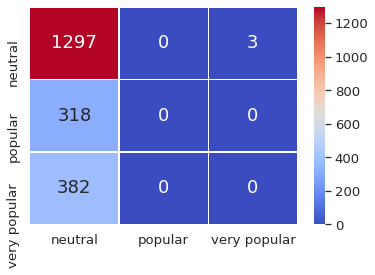

neutral 0.5002197802197802
popular 0.5
very popular 0.49907292954264526


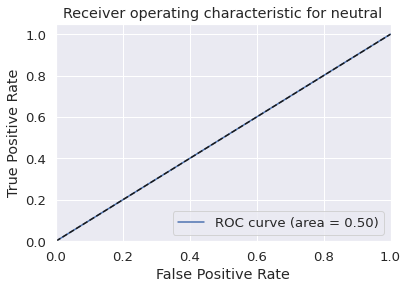

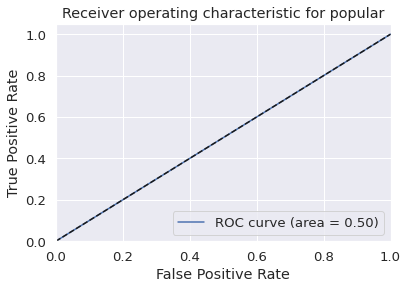

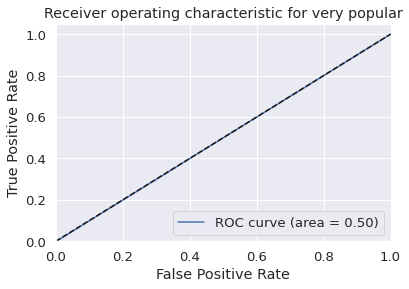

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1).fit(X_train_vec, y_train_lb)
y_pred_svm = clf_svm.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_svm, lb_trained, svm )

No improvement is noticed when changing the embedding method for the SVM model.

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   15.9s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


              precision    recall  f1-score   support

     neutral       0.65      1.00      0.79      1300
     popular       0.00      0.00      0.00       318
very popular       1.00      0.00      0.01       382

    accuracy                           0.65      2000
   macro avg       0.55      0.33      0.26      2000
weighted avg       0.61      0.65      0.51      2000



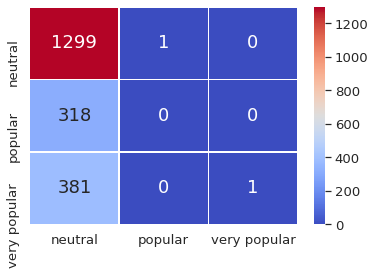

neutral 0.5042307692307693
popular 0.4997027348394768
very popular 0.5013089005235603


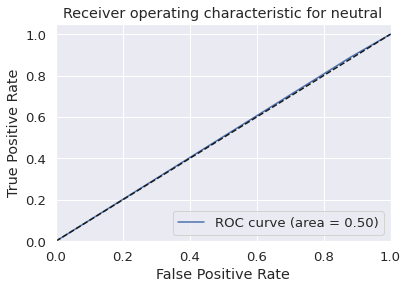

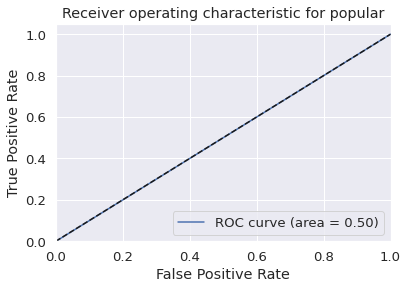

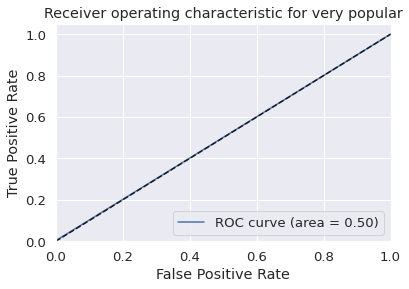

In [0]:
rfc = RandomForestClassifier(n_estimators=300, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_vec, y_train_lb)
y_pred_rfc = rfc.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )

Same for the randomforests method, there is no improvement when we changed the embedding method. The popularity of a comment is difficult to predict. 

One other method would be working with only two labels to have more observations for the popular modality and thus better outcome.


#Sentiment analysis 


Using the labels we created, we try to classify the comments using the previous methods : SVM and Randomforest, using the occurences for the first enmbedding method and comparing it to Word2Vec.

In [0]:
X=base.loc[base['Labels'] != 0].Tokens.array
X = [' '.join(x) for x in X]
print(len(X), X[0])

9988 picturesque perhaps now but wait fate befalls quaint quiet well kept secrets moneyed set big city sweeps in imprints way life whether fits upon unspoiled landscape reinterprets historic architectural language what ken frampton calls vernacular name boutique artisanal every laughable luxury adjective used know quietly communicate unrelenting selfishness conformity makes transformation place related way life possible goodness barney bergdorf can t far behind in signing coveted leases there


In [0]:
y = base.loc[base['Labels'] != 0].Labels
print(y)
print(y.shape)

0       3
1       2
2       2
3       3
4       3
       ..
9995    2
9996    1
9997    3
9998    3
9999    3
Name: Labels, Length: 9988, dtype: int64
(9988,)


In [0]:
y.value_counts()

3    5391
2    3811
1     786
Name: Labels, dtype: int64

In [0]:
# create train 60% 
X_train, X_devtest, y_train, y_devtest = train_test_split(X, y, test_size=0.4, random_state=42)
# create dev 20% test 20% 
X_dev, X_test, y_dev, y_test = train_test_split(X_devtest, y_devtest, test_size=0.5, random_state=42)

In [0]:
#vectorizing X
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer()
X_train_cv = cv.fit_transform(X_train)
X_train_cv.shape

(5992, 23345)

In [0]:
X_dev_cv = cv.transform(X_dev)
X_dev_cv.shape

(1998, 23345)

In [0]:
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb_trained = lb.fit(y_train)
y_train_lb = lb_trained.transform(y_train)
y_dev_lb = lb_trained.transform(y_dev)
print(y_train_lb.shape, y_dev_lb.shape)

(5992, 3) (1998, 3)


In [0]:
#SVM
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1 ).fit(X_train_cv.toarray(), y_train_lb)

[LibLinear][LibLinear][LibLinear]

In [0]:
y_pred_svm = clf_svm.predict(X_dev_cv)
print(y_pred_svm.shape)

(1998, 3)


In [0]:
def show_eval(y_true, y_pred, lb_trained, clf):
  ''' 
  Show eval metrics.  Takes binarized y true and pred along with trained binarizer for label names
  '''
  y_true_names = lb_trained.inverse_transform(y_true)
  y_pred_names = lb_trained.inverse_transform(y_pred)
  print( classification_report(y_true_names, y_pred_names) )
  cm = confusion_matrix(y_true_names, y_pred_names) 
  labels = ['neutral', 'negative', 'positive']
  df_cm = pd.DataFrame(cm, index=labels, columns=labels)
  # config plot sizes
  sn.set(font_scale=1.2)
  sn.heatmap(df_cm, annot=True, annot_kws={"size": 18}, cmap='coolwarm', linewidth=0.5, fmt="")
  plt.show()

  fpr = dict()
  tpr = dict()
  roc_auc = dict()
  for i, label in enumerate(labels):
    fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    print(label, roc_auc[i])

  for i, label in enumerate(labels):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for '+label)
    plt.legend(loc="lower right")
    plt.show()

              precision    recall  f1-score   support

           1       0.15      0.40      0.22       161
           2       0.65      0.59      0.62       758
           3       0.76      0.62      0.69      1079

    accuracy                           0.59      1998
   macro avg       0.52      0.54      0.51      1998
weighted avg       0.67      0.59      0.62      1998



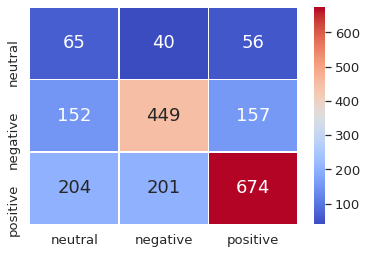

neutral 0.5660119625232878
negative 0.7092571708230487
positive 0.7002211575018581


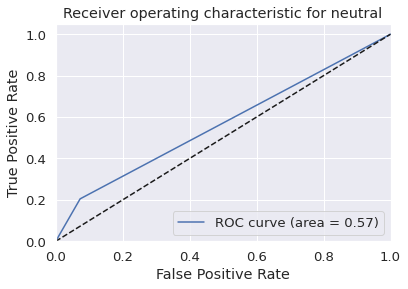

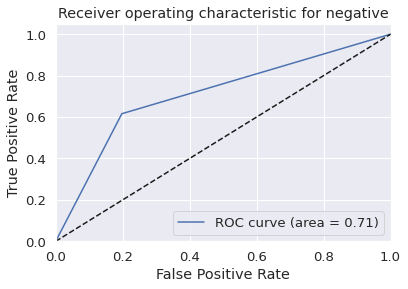

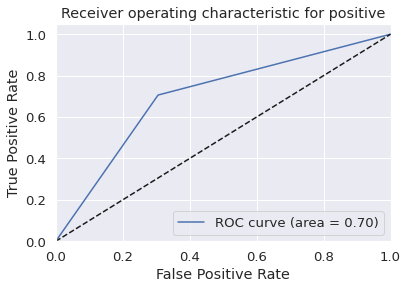

In [0]:
show_eval(y_dev_lb, y_pred_svm, lb_trained, clf_svm)

The prediction in this case is fairly good for the negative and postive sentiments but less optimal for the neutra, due to the low number of observations.

In [0]:
#Randomforest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42,min_samples_split=3, n_jobs=-1, verbose=1)
rfc.fit(X_train_cv, y_train_lb)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   22.6s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.2s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=1,
                       warm_start=False)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.2s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.6s finished


              precision    recall  f1-score   support

           1       0.16      0.36      0.22       161
           2       0.79      0.36      0.50       758
           3       0.69      0.83      0.75      1079

    accuracy                           0.61      1998
   macro avg       0.55      0.52      0.49      1998
weighted avg       0.69      0.61      0.61      1998



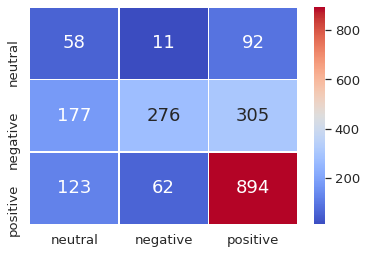

neutral 0.5116058115277069
negative 0.652622563622436
positive 0.6982768270705656


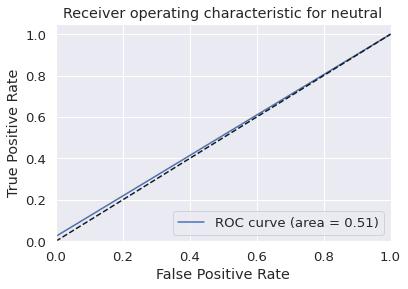

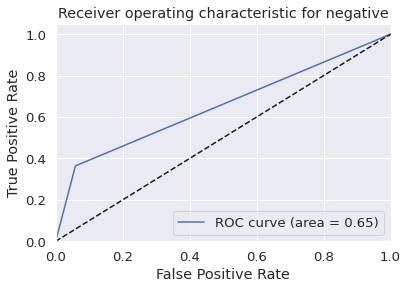

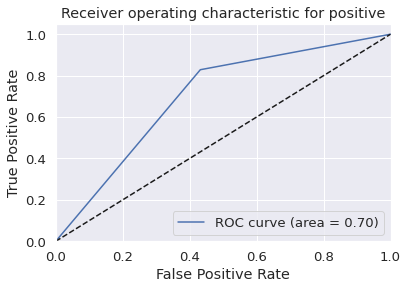

In [0]:
y_pred_rfc = rfc.predict(X_dev_cv)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )

The SVM model is better than Randomforests in sentiment analysis in our case, since negative comments seem to be mistaken for positive ones. 

Let us see now with Word2Vec embedding.

In [0]:
#word2vec
X_train_vec = tokens2vectors(X_train)
print(X_train_vec.shape, X_train_cv.shape)
# print(type(X_train_cv.toarray()), type(X_train_vec))
X_dev_vec = tokens2vectors(X_dev)
X_test_vec = tokens2vectors(X_test)

(5992, 100) (5992, 23345)


[LibLinear][LibLinear][LibLinear]              precision    recall  f1-score   support

           1       0.11      0.40      0.18       161
           2       0.51      0.09      0.15       758
           3       0.61      0.74      0.67      1079

    accuracy                           0.47      1998
   macro avg       0.41      0.41      0.33      1998
weighted avg       0.54      0.47      0.43      1998



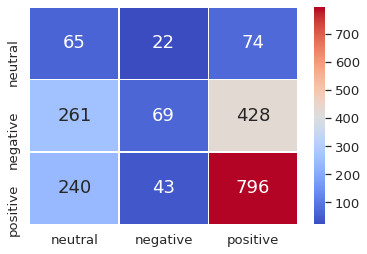

neutral 0.5
negative 0.5193048344539961
positive 0.5934801396932838


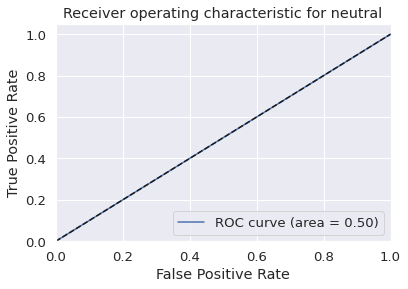

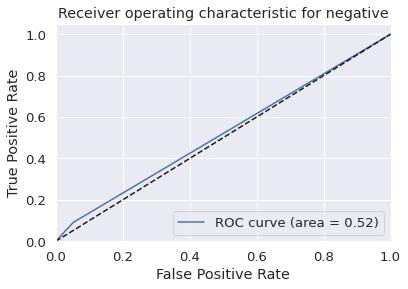

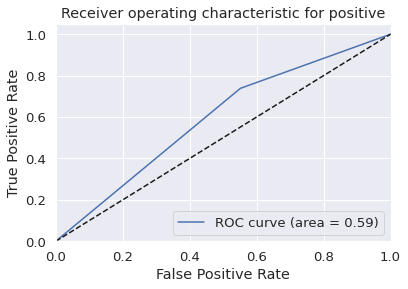

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
svm = LinearSVC(verbose=1, random_state=42)
clf_svm = OneVsRestClassifier(svm, n_jobs=1).fit(X_train_vec, y_train_lb)
y_pred_svm = clf_svm.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_svm, lb_trained, svm )

We see that in this case, the classification is worse that the previous embedding method. The same result is observed for the RandomForest model : 

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed:   22.4s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   25.1s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 446 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 500 out of 500 | elapsed:    0.3s finished


              precision    recall  f1-score   support

           1       0.12      0.50      0.19       161
           2       0.48      0.10      0.16       758
           3       0.59      0.65      0.62      1079

    accuracy                           0.43      1998
   macro avg       0.40      0.41      0.32      1998
weighted avg       0.51      0.43      0.41      1998



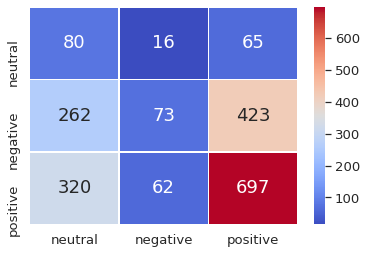

neutral 0.49891126837234623
negative 0.5167014213975657
positive 0.5574782599049416


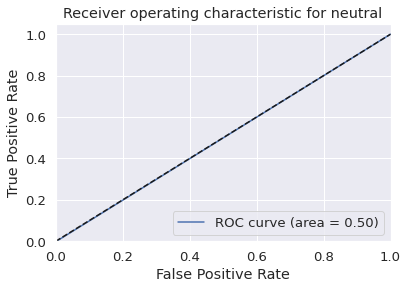

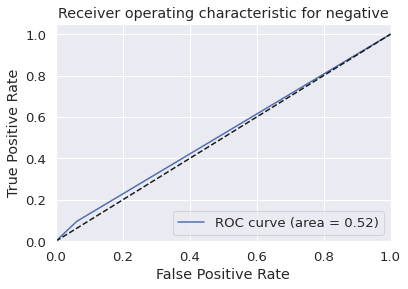

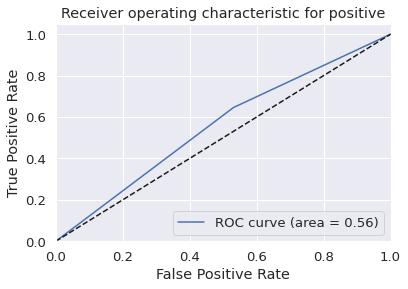

In [0]:
rfc = RandomForestClassifier(n_estimators=500, max_depth=None, random_state=42, n_jobs=-1, verbose=1)
rfc.fit(X_train_vec, y_train_lb)
y_pred_rfc = rfc.predict(X_dev_vec)
show_eval(y_dev_lb, y_pred_rfc, lb_trained, rfc )

BERT : Pretrained Language Model used for sentiment analysis :

In [0]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from transformers import BertTokenizer, AutoModel, AutoTokenizer
import pandas as pd
from torch.utils.data import DataLoader
from sklearn import preprocessing
class SSTDataset(Dataset):

    def __init__(self, database, maxlen, model_name='bert-base-uncased'):

        #Store the contents of the file in a pandas dataframe
        self.df = database

        #Initialize the BERT tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)

        self.maxlen = maxlen

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):

        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.iloc[index, 1]  #'commentBody'
        #tokens = self.df.iloc[index, 2]
        label = self.df.iloc[index, 0]  #'Labels'
        lb = preprocessing.LabelBinarizer()
        #label = lb.fit(label)

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        if self.tokenizer.cls_token is None:
          bos_token = self.tokenizer.bos_token
        else:
          bos_token = self.tokenizer.cls_token
          
        if self.tokenizer.sep_token is None:
          eos_token = self.tokenizer.eos_token
        else:
          eos_token = self.tokenizer.sep_token
        
        tokens = [bos_token] + tokens + [eos_token] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + [self.tokenizer.pad_token for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + [eos_token] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor
        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()

        return tokens_ids_tensor, attn_mask, label

In [0]:
#Creating instances of training and validation set
from sklearn.model_selection import train_test_split
training,test = train_test_split(base, test_size=0.2, random_state=42)

train_set = SSTDataset(database = training, maxlen = 60, model_name='bert-base-uncased')
val_set = SSTDataset(database= test, maxlen = 60, model_name='bert-base-uncased')

#Creating instances of training and validation dataloaders
train_loader = DataLoader(train_set, batch_size = 12, num_workers = 5)
val_loader = DataLoader(val_set, batch_size = 12, num_workers = 5)

In [0]:
train_set.__getitem__(2)

(tensor([  101,  1996,  2158,  2040,  2716, 29591,  1010,  8040,  9691,  1998,
         27885,  4135, 28940,  2100,  2000,  1996,  8495,  1010,  2085,  5363,
          2000,  4895, 17310,  2102,  1037,  3537,  3973,  2700,  2343,  1012,
          6517,   999,   102,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 2)

In [0]:
class SentimentClassifier(nn.Module):

    def __init__(self, pretrained_model_name='bert-base-uncased'):
        super(SentimentClassifier, self).__init__()
        
        #Loading Mask Language Model 
        self.encoder = AutoModel.from_pretrained(pretrained_model_name)
        #we append an extra layer for Classification (it will be randomly initialized)
        self.cls_layer = nn.Linear(self.encoder.pooler.dense.out_features, 1)

    def forward(self, seq, attn_masks):
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        # see in the hugging face doc what to input
        #cont_reps = #  self.encoder(..)..
        cont_reps, _ = self.encoder(seq, attention_mask = attn_masks)
        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits


In [0]:
sentiment_model = SentimentClassifier('bert-base-uncased')
# if gpu mode
sentiment_model = sentiment_model.to("cuda")
# to check if the weights of the model are in gpu : 
# sentiment_model.cls_layer.weight.is_cuda
# can checkout all the layers by running 
sentiment_model

SentimentClassifier(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_af

In [0]:
import torch.nn as nn
import torch.optim as optim
# define the loss and optimizer 
criterion = nn.BCEWithLogitsLoss()
opti = optim.Adam(sentiment_model.parameters(), lr = 2e-5)

In [0]:
import pdb
def train(model, criterion, opti, train_loader, val_loader, max_eps=1, gpu=False, print_every=1,validate_every=1):
    if gpu:
      model = model.to("cuda")
    for ep in range(max_eps):
        
        for it, (seq, attn_masks, labels) in enumerate(train_loader):
            #Clear gradients
            opti.zero_grad()  
            #Converting these to cuda tensors
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits = model(seq, attn_masks)

            #Computing loss
            loss = criterion(logits.squeeze(-1), labels.float())

            #Backpropagating the gradients
            loss.backward()

            #Optimization step
            opti.step()
            if (it + 1) % print_every == 0:
                accuracy = torch.sum((logits>0).int().squeeze(1)==labels)/float(labels.size(0))
                print("Iteration {} of epoch {} complete. Loss : {}, Accuracy {} ".format(it+1, ep+1, loss.item(),accuracy))
            if it>1000:
              break
        if ep % validate_every==0:
          n_batch_validation = 0
          loss_validation = 0
          accuracy_validation = 0
          for it, (seq, attn_masks, labels) in enumerate(val_loader):
            #Clear gradients
            
            if gpu:
              seq, attn_masks, labels = seq.cuda(), attn_masks.cuda(), labels.cuda()
            #Obtaining the logits from the model
            logits_val = model(seq, attn_masks)
            n_batch_validation+=1
            #Computing loss
           
            _loss = float(criterion(logits_val.squeeze(-1), labels.float()))
            _accu = float(torch.sum((logits_val>0).int().squeeze(1)==labels)/float(labels.size(0)))
           
            loss_validation += _loss
            accuracy_validation += _accu
          print("EVALUATION Validation set : mean loss {} n mean accuracy {}".format(loss_validation/n_batch_validation, accuracy_validation/n_batch_validation))

          

In [0]:
train(sentiment_model, criterion, opti, train_loader, val_loader, max_eps=10, print_every=100, gpu=True)

Iteration 100 of epoch 1 complete. Loss : -20.965084075927734, Accuracy 0.0 
Iteration 200 of epoch 1 complete. Loss : -22.46303367614746, Accuracy 0.0 
Iteration 300 of epoch 1 complete. Loss : -25.508726119995117, Accuracy 0.0833333358168602 
Iteration 400 of epoch 1 complete. Loss : -27.248615264892578, Accuracy 0.0 
Iteration 500 of epoch 1 complete. Loss : -27.45784568786621, Accuracy 0.0833333358168602 
Iteration 600 of epoch 1 complete. Loss : -25.768217086791992, Accuracy 0.25 
EVALUATION Validation set : mean loss -31.70155158585417 n mean accuracy 0.07584830529675513
Iteration 100 of epoch 2 complete. Loss : -32.161659240722656, Accuracy 0.0 
Iteration 200 of epoch 2 complete. Loss : -33.92827606201172, Accuracy 0.0 
Iteration 300 of epoch 2 complete. Loss : -37.92486572265625, Accuracy 0.0833333358168602 
Iteration 400 of epoch 2 complete. Loss : -39.91508483886719, Accuracy 0.0 
Iteration 500 of epoch 2 complete. Loss : -39.64518737792969, Accuracy 0.0833333358168602 
Itera

## **4) Conclusion**